In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

filenames = {'IRMS':'Syringe/CDD-IRMS.xlsx',
          'Orbitrap syringe':'Syringe/data/calibrated_deltas_2024-03-21.csv',
             'Orbitrap vanquish':'Vanquish/data/calibrated_deltas_2024-03-19.csv'
            }



## Import and organise deltas

In [4]:
data = filenames.copy()
labels = list(filenames.keys())

# Trim IRMS data to relevant lines, convert to not-permil
data['IRMS'] = pd.read_excel(filenames['IRMS'])[33:]
data['IRMS'][data['IRMS'].columns[1:]] = data['IRMS'][data['IRMS'].columns[1:]].copy()*1e-3
# Shift sample n to n+1 - if applicable
data['IRMS'].index = [int(name.split('-')[-1])+0 for name in data['IRMS']['sample_name']]

# Sort Orbitrap data similarly
for label in labels:
    if label != 'IRMS':
        data[label] = pd.read_csv(filenames[label])
        data[label].index = [int(name.split('-')[-1]) for name in data[label]['sample_name']]
    
    # ignore data without IRMS values
    common_id = [ i for i in data['IRMS'].index if i in data[label].index]
    data[label]=data[label].loc[common_id]
    

# Calculate D17O values and errors       
for j,label in enumerate(data.keys()):
    data[label]['mean_D17O'] = data[label]['mean_d17O']-0.52*data[label]['mean_d18O']
    if label == 'IRMS':
        data[label]['err_D17O']=0.3e-3
    else:
        data[label]['err_D17O'] = np.sqrt( data[label]['err_d17O']**2 + 0.52*data[label]['err_d18O']**2 )

        
# Display
for label,df in data.items():
    print('Imported '+label+ ' data')
    # print(pd.concat([df.head(2), df.tail(2)]))
    print(df)


Imported IRMS data
       sample_name  mean_d15N  mean_d17O  mean_d18O  err_d15N  err_d17O  \
280  CDD16-C01-280   0.001442   0.049904   0.061225    0.0003  0.002338   
281  CDD16-C01-281   0.002786   0.055780   0.063255    0.0003  0.002338   
282  CDD16-C01-282   0.002043   0.056491   0.067849    0.0003  0.002338   
284  CDD16-C01-284   0.002500   0.049011   0.055957    0.0003  0.002338   
285  CDD16-C01-285   0.002867   0.056485   0.066479    0.0003  0.002338   
286  CDD16-C01-286   0.001475   0.061466   0.072592    0.0003  0.002338   
287  CDD16-C01-287   0.002030   0.049402   0.057670    0.0003  0.002338   
288  CDD16-C01-288   0.001085   0.060977   0.071029    0.0003  0.002338   
289  CDD16-C01-289   0.002321   0.056864   0.063573    0.0003  0.002338   

     err_d18O  mean_D17O  err_D17O  
280  0.003793   0.018067    0.0003  
281  0.003793   0.022887    0.0003  
282  0.003793   0.021209    0.0003  
284  0.003793   0.019914    0.0003  
285  0.003793   0.021916    0.0003  
286  0.0

## Plots

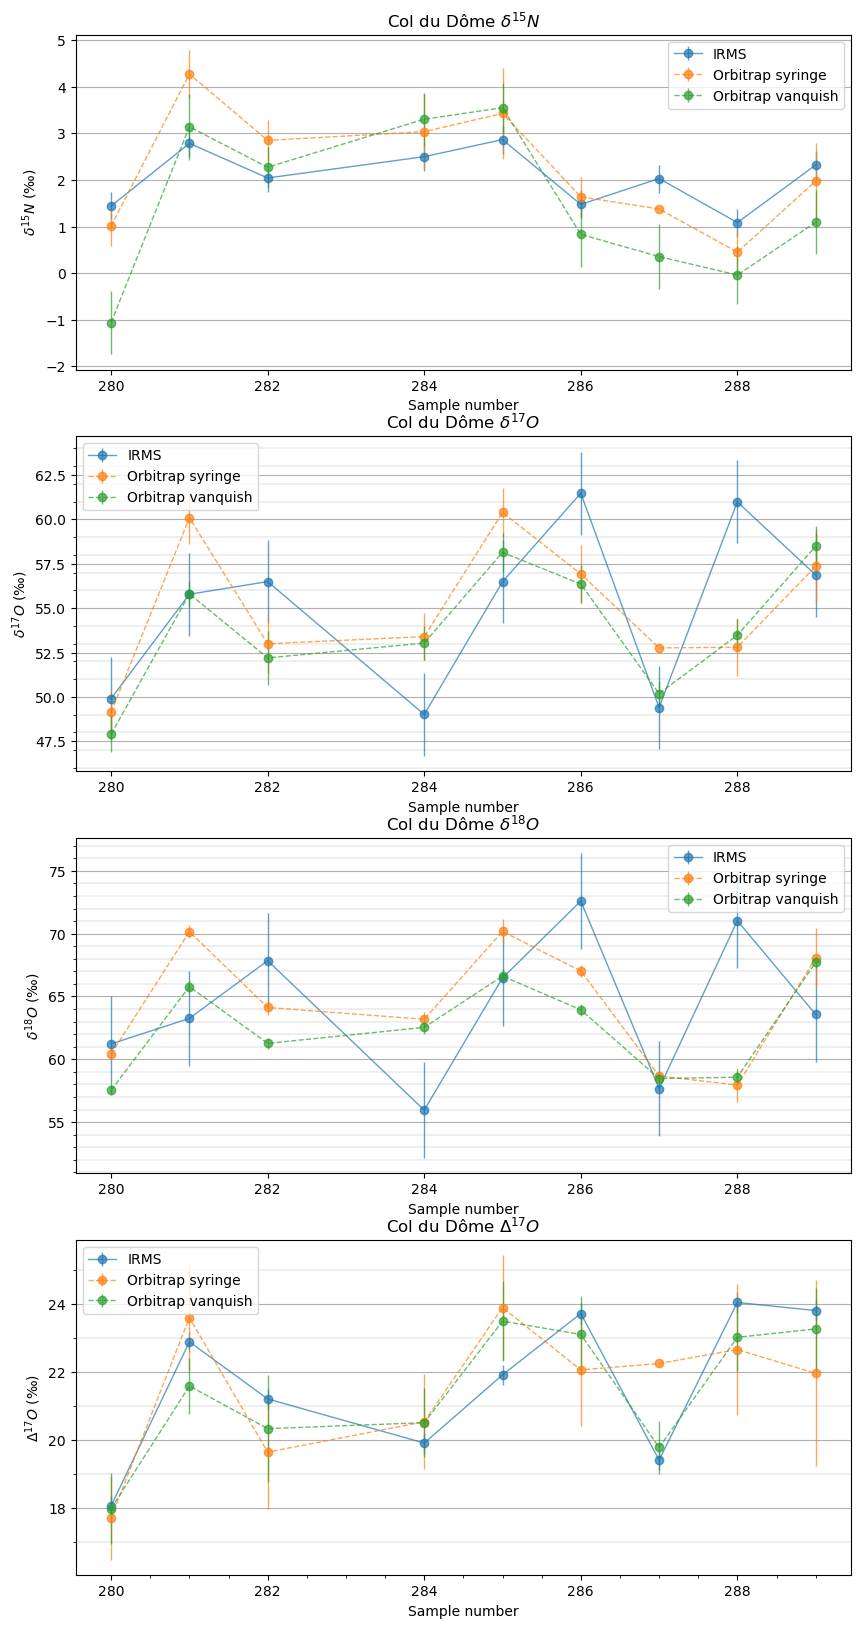

In [6]:
isotopologues = [ col[-4:] for col in data['IRMS'].columns if col.startswith('mean_')]

fig,ax = plt.subplots(4,1, figsize=[10,20])

# Plot isotopologues
for i,isotope in enumerate(isotopologues):
    for j,label in enumerate(data.keys()):
        if 'mean_'+isotope in data[label].columns:
            # plot data with errorbars - solid for IRMS, dashed for Orbitrap
            if label == 'IRMS':
                ax[i].errorbar(data[label].index, data[label]['mean_'+isotope]*1e3, yerr = data[label]['err_'+isotope]*1e3, label=label,lw=1,marker='o',ls='-',alpha=.7)
            else:
                ax[i].errorbar(data[label].index, data[label]['mean_'+isotope]*1e3, yerr = data[label]['err_'+isotope]*1e3, label=label,lw=1,marker='o',ls='--',alpha=0.7)
 
    # plot parameters
    ax[i].set_xlabel('Sample number')
    if isotope.startswith('d'):
        ax[i].set_title('Col du Dôme $\delta^{'+isotope[1:3]+'}'+isotope[3]+'$')
        ax[i].set_ylabel('$\delta^{'+isotope[1:3]+'}'+isotope[3]+'$ (‰)')
    elif isotope.startswith('D'):
        ax[i].set_title('Col du Dôme $\Delta^{'+isotope[1:3]+'}'+isotope[3]+'$')
        ax[i].set_ylabel('$\Delta^{'+isotope[1:3]+'}'+isotope[3]+'$ (‰)')
    plt.minorticks_on()
    ax[i].yaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(axis='y')
    ax[i].grid(axis='y', which='minor',lw=0.3)
    ax[i].legend()


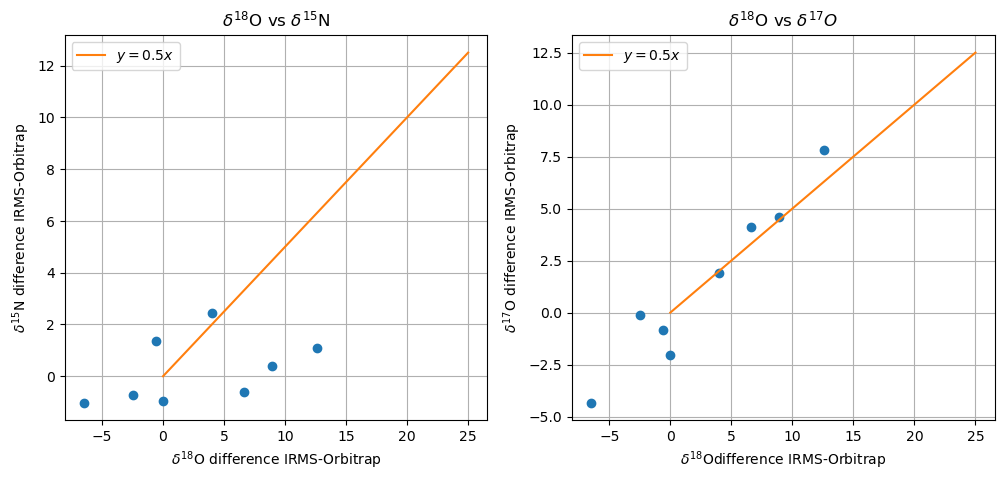

In [55]:
cols = [isotope+'_diff' for isotope in isotopologues ]
diff = pd.DataFrame(columns=['sample.name']+cols)
diff['sample_name']=data['Orbitrap vanquish']['sample_name']
for i,isotope in enumerate(isotopologues):
    diff[cols[i]] = data['IRMS']['mean_'+isotope]-data['Orbitrap vanquish']['mean_'+isotope]

y1 = diff['d15N_diff']*1e3
y2 = diff['d17O_diff']*1e3
x = diff['d18O_diff']*1e3

fig,axes=plt.subplots(1,2,figsize=[12,5])

ax=axes[0]
ax.plot(x,y1,lw=0,marker='o')
ax.plot([0,25],[0,12.5],label='$y=0.5x$')
ax.set_xlabel('$\delta^{18}$O difference IRMS-Orbitrap')
ax.set_ylabel('$\delta^{15}$N difference IRMS-Orbitrap')
ax.set_title('$\delta^{18}$O vs $\delta^{15}$N')
ax.legend()
ax.grid()

ax=axes[1]
ax.plot(x,y2,lw=0,marker='o')
ax.plot([0,25],[0,12.5],label='$y=0.5x$')
ax.set_xlabel('$\delta^{18}$Odifference IRMS-Orbitrap')
ax.set_ylabel('$\delta^{17}$O difference IRMS-Orbitrap')
ax.set_title('$\delta^{18}$O vs $\delta^{17}O$')
ax.grid()
ax.legend()

# fig.savefig(folder+'/correlations.png')

/var/folders/rr/bz6rnlcn09b6b2ttxx8h8x5m0000gn/T/ipykernel_79906/3518003271.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=90);


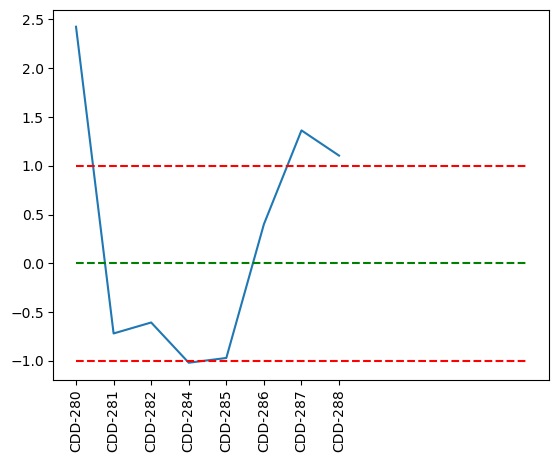

In [59]:
plt.plot(diff['sample_name'],diff['d15N_diff']*1e3)
plt.plot([0,12],[0,0],c='g',ls='--')
plt.plot([0,12],[1,1],c='r',ls='--')
plt.plot([0,12],[-1,-1],c='r',ls='--')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=90);

In [58]:
diff

,sample.name,d15N_diff,d17O_diff,d18O_diff,D17O_diff,sample_name
280,NaN,0.002425,0.001885,0.003978,-0.000183,CDD-280
281,NaN,-0.000719,-0.000111,-0.002465,0.001171,CDD-281
282,NaN,-0.000606,0.004135,0.006612,0.000697,CDD-282
284,NaN,-0.001019,-0.004328,-0.006489,-0.000954,CDD-284
285,NaN,-0.000970,-0.002051,-0.000023,-0.002040,CDD-285
286,NaN,0.000401,0.004579,0.008902,-0.000050,CDD-286
287,NaN,0.001362,-0.000851,-0.000600,-0.000539,CDD-287
288,NaN,0.001104,0.007822,0.012601,0.001269,CDD-288


(-3.0, 3.0)

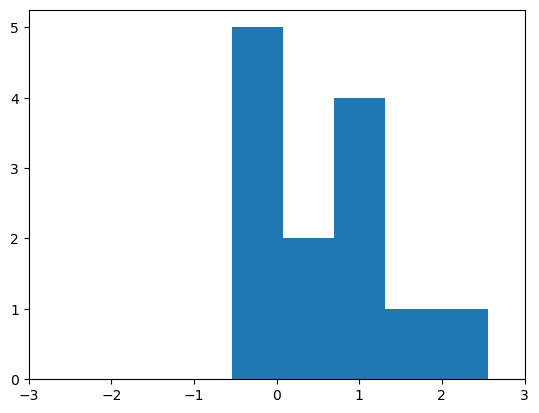

In [184]:
plt.hist(diff['d15N_diff'],bins=5)
plt.xlim([-3,3])

In [192]:
ans=(0.01*1e6*10*1000) * 0.4e-2*0.6e-2 * 100 
ans**-0.5

0.002041241452319315